# Abrupt Fires and Landslides
Authors: Nick Colaianne, David Cúñes, Sebastien Lenard, Jill Marshal, Emily Rexer

Main notebook for integrating code. 

## Background and Motivation
TODO: Explain why this project is relevant and what we hope to discover

Mass wasting and landslides are major processes affecting the erosion of the Earth's surface. But their study remains difficult as the erosion products can be rapidly evacuated during the raining season. Numerical modeling allows to improve our knowledge of landsliding by simulating mountains and processes through numerical solving of the mathematical equations of the processes.

Here, we focus on a year-timescale question. How the alternance of a dry/fire season with a wet/rain season affect the properties of the soil? Which impact on the volume of shallow landslides (i.e. soil mass wasting) during an extreme rainfall event, at the following of an extreme fire?

Setting: a small drainage basin in Oregon.

## Table of Contents
1. Initializing the Grid and its fields (DEM, topographic and soil properties).
2. [Stochastic Fire](https://landlab.readthedocs.io/en/latest/reference/components/fire_generator.html).
3. Soil Cohesion and Density.
3. [Shallow Landslide Susceptibility](https://landlab.readthedocs.io/en/latest/reference/components/landslides.html).
4. Trigger a Landslide.
5. Sediment flux.

potential sections: [vegetation](https://landlab.readthedocs.io/en/latest/reference/components/vegetation_dynamics.html), [rainfall](https://landlab.readthedocs.io/en/latest/reference/components/uniform_precip.html), [SPACE](https://landlab.readthedocs.io/en/latest/reference/components/space.html#module-landlab.components.space.space_large_scale_eroder)

### Resources
[all landlab components](https://landlab.readthedocs.io/en/latest/reference/components/index.html#api-components)

We start to import all libraries required by this tutorial.

In [2]:
from bmi_topography import Topography # includes the BMI library to import the DEM of the drainage basin
import copy

# Libraries for scientific computing (ndarrays) and plotting
import numpy as np
import matplotlib as mpl; import matplotlib.pyplot as plt

# Landlab libraries/methods
from landlab.io import read_esri_ascii # library to read the file of the downloaded DEM
from landlab import RasterModelGrid, imshowhs_grid, imshow_grid # Component to manage the grid and methods for display
from landlab.components import FlowAccumulator #, PriorityFloodFlowRouter, ChannelProfiler, BedrockLandslider

#import sys, time, os
#from pathlib import Path
#, write_esri_ascii
#from landlab.io.netcdf import read_netcdf
#from landlab.utils import get_watershed_mask

## 1. Initializing the Grid and its fields (DEM, topographic and soil properties).
Here, we get the 30m-STRM DEM covering a drainage basin in Oregon to create the grid on which the tutorial will work. Then, we compute the topographic slope and topographic drainage area, which are added to the grid as fields for the landslide component. We also determine and add soil properties, which are needed by the landlide component to compute landslide failure probability.

### 1.1 Download the DEM.

We download the DEM.

In [12]:
# imports the DEM into the memory (note: a warning is raised from the demo key). Requires the BMI library bmi_topography
topo = Topography(
    dem_type="SRTMGL1",
    south=43.971911,
    north=43.982382,
    west=-123.826646,
    east=-123.813606,
    output_format="AAIGrid",
    cache_dir="DEMData//")

We get some cache information and properties of the DEM and display the DEM, and convert it into a new DEM with coordinates and cell-spacing in meters (rather than in degrees) **(TODO: check this assertion)**.

/home/jupyter-sebastien.lenard@g-244c0/abrupt-perturbations/abrupt_fire_landslide/DEMData/SRTMGL1_43.971911_-123.826646_43.982382_-123.813606.asc
<xarray.DataArray 'SRTMGL1' (band: 1, y: 38, x: 47)>
array([[[286, 289, ..., 304, 311],
        [293, 292, ..., 310, 315],
        ..., 
        [240, 240, ..., 468, 470],
        [247, 248, ..., 463, 466]]], dtype=int32)
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 43.98 43.98 43.98 43.98 ... 43.97 43.97 43.97 43.97
  * x        (x) float64 -123.8 -123.8 -123.8 -123.8 ... -123.8 -123.8 -123.8
Attributes:
    transform:   (0.000277777778, 0.0, -123.826805555548, 0.0, -0.00027777777...
    res:         (0.000277777778, 0.000277777778)
    is_tiled:    0
    nodatavals:  (-32768.0,)
    scales:      (1.0,)
    offsets:     (0.0,)
    units:       meters
    location:    node


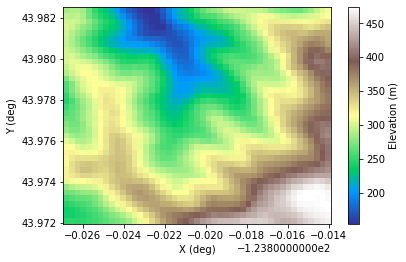

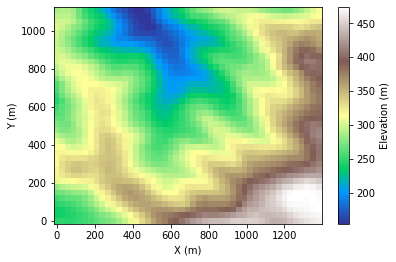

In [31]:
fname = topo.fetch(); print(fname)
dem = topo.load(); print(dem)

# Instantiates the RasterModelGrid by reading the ascii DEM file. 
# The coordinates and spacing are in degrees. The elevation field for this DEM and 
# the other fields referring to the DEM are named "topographic__elevation".
# the following returns the RasterModelGrid object and the array of elevations
grid_geog, elev = read_esri_ascii(fname, name='topographic__elevation')     

# Plot the DEM
plt.figure()
cmap = copy.copy(mpl.cm.get_cmap("terrain"))
imshow_grid(grid_geog, 'topographic__elevation', cmap =cmap,
            grid_units=("deg", "deg"), colorbar_label="Elevation (m)")
plt.show()

# We now need to create a second RasterModelGrid from this grid, to define the coordinates and 
# cell spacing  in meters 
# (30 meters, rather than the resolution in degrees indicated in the ascii files 0.000277777778)
grid = RasterModelGrid ((grid_geog.number_of_node_rows, grid_geog.number_of_node_columns), 30) # 30 meters
grid.add_field('topographic__elevation', elev, at = 'node')

num_rows, num_columns = grid.shape 
node_spacing = grid.dx

# Plot the DEM
plt.figure()
imshow_grid(grid, 'topographic__elevation', cmap =cmap,
            grid_units=("m", "m"), colorbar_label="Elevation (m)")
plt.show()

### 1.2. Calculates the topographic properties.

(a) We now compute the slope from the elevations of the grid.

Doc: https://landlab.readthedocs.io/en/master/reference/grid/gradients.html.

[ 0.2411752   0.22435501  0.1656508  ...,  0.39830079  0.30220918
  0.2510086 ]


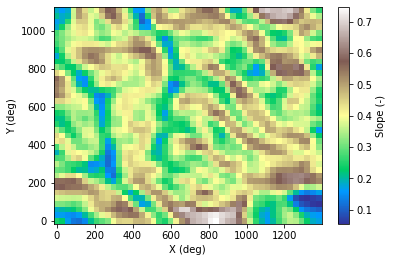

In [32]:
# NB : this computation doesn't work if cell spacing is in degrees.

topographic_slope = grid.calc_slope_at_node(elevs='topographic__elevation')
# I expect that calc_slope_at_node computes the tangent, i.e. the ratio of the vertical to the horizontal side, 
#also called the slope of the line
slopes = grid.add_field('topographic__slope', topographic_slope, at='node', clobber=True) # without units, 
# should be the tangent of slope angle
print(np.arctan(slopes))
# Plot the slopes
plt.figure()
imshow_grid(grid, 'topographic__slope', cmap =cmap,
            grid_units=("deg", "deg"), colorbar_label="Slope (-)")
plt.show()

(b) And we compute the drainage area (specific contributing area) from the grid DEM supplied.
This should be  calculated as upslope drainage area/unit contour length (e.g., grid cell width) using the multiple flow direction D-infinity approach of TauDEM. 
(http://hydrology.usu.edu/taudem/taudem5/index.html). 

Here, we first close all the sides of the grid except the north side and then instantiate and the FlowAccumulator component, using the SteepestDescent algorithm.

**TODO: check the plot, doesn't look similar to what could be expected (should have higher flow in the north)**

[ 247.  248.  247. ...,  294.  304.  311.]
[    0.     0.     0. ...,  7200.  8100.     0.]


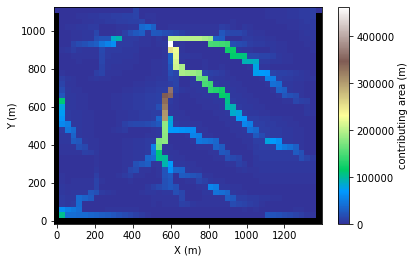

In [36]:
grid.set_closed_boundaries_at_grid_edges(True, False, True, True) # right, top, left, bottom. True indicates closed

# Instantiation of the Flow accumulator with the steepest descent algorithm
fa = FlowAccumulator(
     grid, 'topographic__elevation', flow_director='FlowDirectorSteepest'
)
print(fa.surface_values)
fa.run_one_step() # run of the flow accumulator only once
# Affecting the specific contributing area (drainage basin)
contributingAreas = grid.add_field('topographic__specific_contributing_area', grid.at_node['drainage_area'], at='node', clobber=True) # in m
print(contributingAreas)

# plotting the contributing areas
plt.figure()
imshow_grid(grid, 'topographic__specific_contributing_area', cmap =cmap,
            grid_units=("m", "m"), colorbar_label="contributing area (m)")
plt.show()

### 1.3. Initializing the soil properties.

## 2. Stochastic Fire

## 3. Soil Cohesion and Density

## 4. Shallow Landslide Susceptibility

## 5. Trigger a Landslide